In [1]:
#importing the Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
#Activation Functions and loss function as Categorical cross entropy and one hot encoding

#1.Ada-Act Activation function g(x) = k0+k1*x and its derivative d(g(x))/dx = k1
def ada_act(x,k0,k1):
    return k0+k1*x

def ada_act_der(Z):
    return k1

#2.softmax activation Function
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#3.Loss function 
def categorical_crossentropy(y_true,y_pred):
    return -np.sum(y_true*np.log(y_pred+1e-10))/y_true.shape[0]

#4.one hot encoding
def one_hot_encoding(y):
    n_classes = np.max(y)+1
    return np.eye(n_classes)[y]

In [3]:
# Defining our assumed MLP architecture with two hidden layers
class MLP:
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, k0_h1, k1_h1, k0_h2, k1_h2):
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim
        self.k0_h1 = k0_h1
        self.k1_h1 = k1_h1
        self.k0_h2 = k0_h2
        self.k1_h2 = k1_h2

        # Initialize weights and biases for each layer and assuming the stdandard normal distribution
        self.w1 = np.random.randn(input_dim, hidden_dim1)
        self.b1 = np.random.randn(hidden_dim1)
        self.w2 = np.random.randn(hidden_dim1, hidden_dim2)
        self.b2 = np.random.randn(hidden_dim2)
        self.w3 = np.random.randn(hidden_dim2, output_dim)
        self.b3 = np.random.randn(output_dim)
         
        #Forward Propagation of network
    def forward_propagation(self, X):
        z1 = np.dot(X, self.w1) + self.b1
        a1 = ada_act(z1, self.k0_h1, self.k1_h1)

        z2 = np.dot(a1, self.w2) + self.b2
        a2 = ada_act(z2, self.k0_h2, self.k1_h2)

        z3 = np.dot(a2, self.w3) + self.b3
        a3 = softmax(z3)

        return a1, a2, a3
    
        
        #Backward propagtaion of network
    def backward_propagation(self, X, y, a1, a2, a3, learning_rate):
        m = X.shape[0]

        # Compute gradients for the output layer
        dz3 = a3 - y
        dw3 = np.dot(a2.T, dz3) / m
        db3 = np.mean(dz3, axis=0) 

        # Compute gradients for the second hidden layer
        da2 = np.dot(dz3, self.w3.T)
        dz2 = da2 * self.k1_h2
        dw2 = np.dot(a1.T, dz2) / m
        db2 = np.mean(dz2, axis=0) 

        # Compute gradients for the first hidden layer
        da1 = np.dot(dz2, self.w2.T)
        dz1 = da1 * self.k1_h1
        dw1 = np.dot(X.T, dz1) / m
        db1 = np.mean(dz1, axis=0) 

        # Update weights and biases using gradient descent
        self.w1 -= learning_rate * dw1
        self.b1 -= learning_rate * db1
        self.w2 -= learning_rate * dw2
        self.b2 -= learning_rate * db2
        self.w3 -= learning_rate * dw3
        self.b3 -= learning_rate * db3
        
        
        #Training of neural network
    def train(self, X_train, y_train, X_test, y_test, num_epochs, learning_rate):
        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        weight_updates = []

        for epoch in range(num_epochs):
            # Forward propagation
            a1, a2, a3 = self.forward_propagation(X_train)

            # Compute loss and accuracy for training set
            train_loss = categorical_crossentropy(y_train, a3)
            train_losses.append(train_loss)
            train_pred_labels = np.argmax(a3, axis=1)
            train_true_labels = np.argmax(y_train, axis=1)
            train_acc = accuracy_score(train_true_labels, train_pred_labels)
            train_accs.append(train_acc)

            # Backward propagation and weight updates
            self.backward_propagation(X_train, y_train, a1, a2, a3, learning_rate)

            # Compute loss and accuracy for test set
            a1_test, a2_test, a3_test = self.forward_propagation(X_test)
            test_loss = categorical_crossentropy(y_test, a3_test)
            test_losses.append(test_loss)
            test_pred_labels = np.argmax(a3_test, axis=1)
            test_true_labels = np.argmax(y_test, axis=1)
            test_acc = accuracy_score(test_true_labels, test_pred_labels)
            test_accs.append(test_acc)
            
            
            # Save the weight updates for each layer
            weight_updates.append((np.copy(self.w1), np.copy(self.b1), np.copy(self.w2), np.copy(self.b2), np.copy(self.w3), np.copy(self.b3)))
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

        return train_losses, test_losses, train_accs, test_accs,weight_updates
    
    
    def predict(self, X):
        _, _, predictions = self.forward_propagation(X)
        return np.argmax(predictions, axis=1)


In [4]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

In [5]:
#one hot encoding
y_encoded = one_hot_encoding(y)

In [6]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [7]:
# Normalize the input features (optional but recommended)
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)


In [8]:
# Initialize the MLP with the specified architecture and parameters
input_dim = X_train.shape[1]
hidden_dim1 = 16
hidden_dim2 = 8
output_dim = y_train.shape[1]  # Number of classes
k0_h1, k1_h1 = np.random.randn(), np.random.randn()
k0_h2, k1_h2 = np.random.randn(), np.random.randn()

In [14]:
mlp = MLP(input_dim, hidden_dim1, hidden_dim2, output_dim, k0_h1, k1_h1, k0_h2, k1_h2)

# Set hyperparameters
num_epochs = 100
learning_rate = 0.01

# Train the model and get the evaluation metrics
train_losses, test_losses, train_accs, test_accs,weight_updates = mlp.train(
    X_train, y_train, X_test, y_test, num_epochs, learning_rate
)


Epoch 1/100, Train Loss: 8.4827, Test Loss: 8.9482, Train Acc: 0.5083, Test Acc: 0.4667
Epoch 2/100, Train Loss: 8.1236, Test Loss: 8.5586, Train Acc: 0.5083, Test Acc: 0.4333
Epoch 3/100, Train Loss: 8.0801, Test Loss: 4.9950, Train Acc: 0.4083, Test Acc: 0.4333
Epoch 4/100, Train Loss: 5.0570, Test Loss: 1.5439, Train Acc: 0.4250, Test Acc: 0.6667
Epoch 5/100, Train Loss: 1.5262, Test Loss: 0.2851, Train Acc: 0.6167, Test Acc: 0.8333
Epoch 6/100, Train Loss: 0.3315, Test Loss: 0.1120, Train Acc: 0.9083, Test Acc: 1.0000
Epoch 7/100, Train Loss: 0.1790, Test Loss: 0.0760, Train Acc: 0.9333, Test Acc: 1.0000
Epoch 8/100, Train Loss: 0.1328, Test Loss: 0.0651, Train Acc: 0.9500, Test Acc: 1.0000
Epoch 9/100, Train Loss: 0.1146, Test Loss: 0.0603, Train Acc: 0.9583, Test Acc: 1.0000
Epoch 10/100, Train Loss: 0.1073, Test Loss: 0.0579, Train Acc: 0.9583, Test Acc: 1.0000
Epoch 11/100, Train Loss: 0.1037, Test Loss: 0.0565, Train Acc: 0.9583, Test Acc: 1.0000
Epoch 12/100, Train Loss: 0.10

In [15]:
# Predict on the test set
y_pred = mlp.predict(X_test)

# Convert one-hot encoded labels back to original labels
y_test_original = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred)

# Calculate the F1-score
f1_score_value = f1_score(y_test_original, y_pred, average='weighted')


In [16]:
#printing the values
print("Final Parameter Values:")
print("Weight 1:", mlp.w1)
print("Bias 1:", mlp.b1)
print("Weight 2:", mlp.w2)
print("Bias 2:", mlp.b2)
print("Weight 3:", mlp.w3)
print("Bias 3:", mlp.b3)


Final Parameter Values:
Weight 1: [[-1.12227582e-01 -5.04136053e-01  2.04456023e+00 -1.98367302e+00
  -6.07512108e-01  1.03841982e+00 -1.79393241e+00 -1.61402252e+00
  -8.76402712e-01 -6.82653764e-01 -5.44430365e-01  1.63305570e+00
   8.40899176e-01 -1.32131255e+00 -1.63064162e+00  1.44506603e-03]
 [ 7.80821689e-03 -1.19391000e+00 -4.17480967e-01 -5.32338223e-01
   1.02533759e+00  2.38609974e-02 -5.50969675e-01 -4.72362009e-02
  -1.64120198e+00 -6.68056973e-01 -6.71467333e-03 -2.10687554e+00
   6.14337092e-01 -1.07987317e+00 -4.08365004e-01 -6.46592349e-01]
 [-7.08837898e-01 -7.31106008e-01 -1.93305113e+00 -6.71078162e-01
   9.13256468e-01  2.45231323e-01 -2.60804622e+00  6.22603045e-01
   2.59669651e-01  4.05810213e-01  9.53566344e-01 -1.38128814e-03
   2.02035965e+00  1.53240720e+00 -9.30027956e-01  3.89330991e-01]
 [ 1.79807496e-01 -1.22265716e+00  1.02541367e+00  4.24992460e-01
  -1.33719983e+00  1.01916791e+00  1.93898755e-01 -2.73774580e-01
  -1.05056053e-01 -1.09966437e+00 -6.39

In [17]:
#for confusion Matrix

print("Confusion Matrix:")
print(conf_matrix)
print("F1-score:", f1_score_value)

Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  1 10]]
F1-score: 0.966750208855472


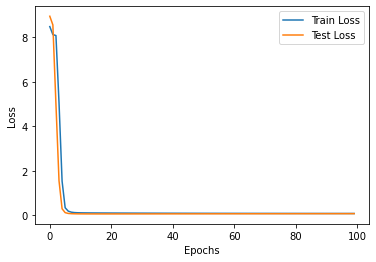

In [18]:
# Plot the loss function vs. epochs
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()